# Première implementation des modèles

Ce notebook est fait pour faire des tests sur l'implémentation des modèles, de la génération des données, des graphiques, etc.

In [1]:
%load_ext autoreload
%autoreload 2
%cd ..

/home/mbenj/3A/3A/ENSAE/smc_movement_models


In [113]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from smc_movement_models.models import estimate_a1_a2_on_window, estimate_a1_a2_on_window_SMC2, run_smc, run_smc2
from smc_movement_models.plots import plot_graph_values, plot_real_data

np.random.seed(42)

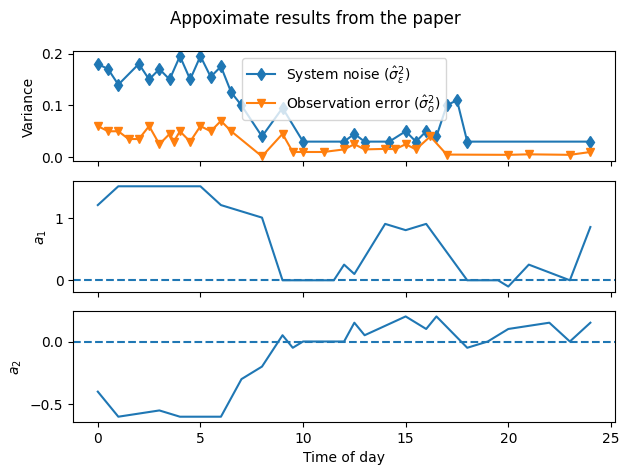

In [3]:
gv_fig = plot_graph_values(figsize=None)

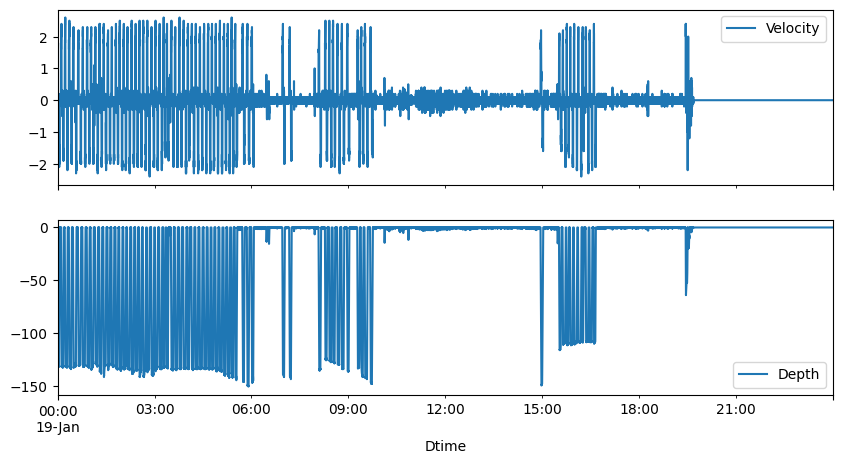

In [8]:
day_fig = plot_real_data("data/19_01_2008.csv", figsize=(10, 5))

In [97]:
summary = pd.read_csv("data/summary.csv")

In [98]:
summary

,Min_Time,Max_Time,Calib_Depth_NaNs,Orig_Depth_NaNs,Velocity_NaNs,Observations
0,2008-01-14 08:37:15,2008-01-14 23:59:55,570,570,0,11073
1,2008-01-15 00:00:00,2008-01-15 23:59:55,994,994,0,17280
2,2008-01-16 00:00:00,2008-01-16 23:59:55,1321,1321,0,17280
3,2008-01-17 00:00:00,2008-01-17 23:59:55,1046,1046,0,17280
4,2008-01-18 00:00:00,2008-01-18 23:59:55,866,866,0,17280
5,2008-01-19 00:00:00,2008-01-19 23:59:55,3638,3638,0,17280
6,2008-01-20 00:00:00,2008-01-20 23:59:55,17280,17280,0,17280
7,2008-01-21 00:00:00,2008-01-21 23:59:55,17280,17280,0,17280
8,2008-01-22 00:00:00,2008-01-22 23:59:55,17280,17280,0,17280
9,2008-01-23 00:00:00,2008-01-23 23:59:55,4823,4823,0,17280


In [9]:
df = pd.read_csv("data/clean_data.csv")

In [10]:
# day_str = "26/01/2008"
day_str_min = "18/01/2008"
day_str_max = "18/01/2008"
mask_day = (df["Date"] >= day_str_min) & (df["Date"] <= day_str_max)
day = df.loc[mask_day, ["Dtime", "Velocity", "Depth"]]
day["Dtime"] = pd.to_datetime(day["Dtime"])

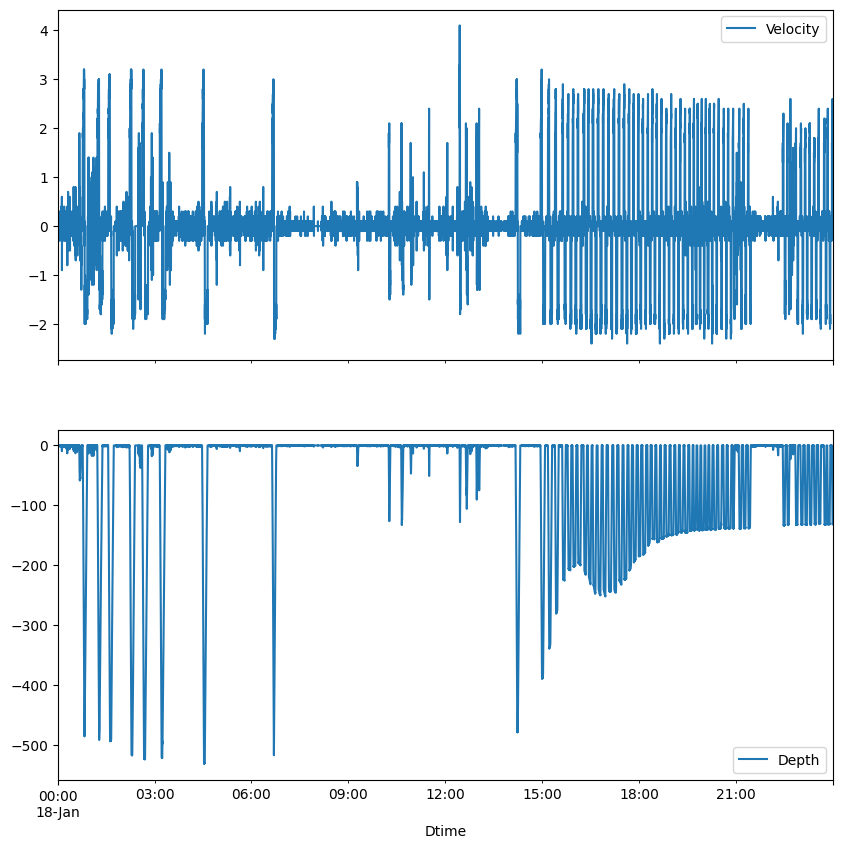

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(10, 10))

day.plot(x="Dtime", y="Velocity", ax=ax1)
day.plot(x="Dtime", y="Depth", ax=ax2);
fig.savefig('day_routine.png', bbox_inches='tight')

In [67]:
window_size = 312
overlap_size = int(window_size / 2)
num_windows = int((len(day) - overlap_size) / overlap_size)

windows = []
ids = []
for i in range(num_windows):
    window = day[i * overlap_size : (i + 2) * overlap_size - 1]["Velocity"].values
    ids.append((i + 1) * overlap_size)
    windows.append(window)

In [68]:
len(windows)

109

In [69]:
final_a1s, final_a2s = estimate_a1_a2_on_window(window, N=500, M=10, epsilon=0.1, alpha=0.5)

In [70]:
def test_var(sigma_o, sigma_e):
    last_a1s = []
    last_a2s = []
    for i in tqdm(range(10)):
        final_a1s, final_a2s = estimate_a1_a2_on_window(window, N=500, M=10, epsilon=0.1, alpha=0.5, sigma = [sigma_o, sigma_e])
        last_a1s.append(final_a1s[-1])
        last_a2s.append(final_a2s[-1])
    return last_a1s, last_a2s

In [73]:
time_a1s = []
time_a2s = []
var_a1s = []
var_a2s = []
for window in tqdm(windows):
    final_a1s, final_a2s = estimate_a1_a2_on_window(window, N=500, M=10, epsilon=0.1, alpha=0.5, sigma = [0.5,0.5])
    time_a1s.append(final_a1s)
    time_a2s.append(final_a2s)
    #var1, var2 = test_var(0.5, 0.5)
    #var_a1s.append(var1)
    #var_a2s.append(var2)
#var_a1s = np.array(var_a1s)
#var_a2s = np.array(var_a2s)
time_a1s = np.array(time_a1s)
time_a2s = np.array(time_a2s)
time_results = pd.DataFrame(
    {
        "Dtime": day["Dtime"].iloc[ids],
        "a1s": time_a1s[:, -1].mean(axis=1),
        "a2s": time_a2s[:, -1].mean(axis=1),
    }
)

100%|█████████████████████████████████████████| 109/109 [01:10<00:00,  1.54it/s]


In [141]:
time_results = pd.DataFrame(
    {
        "Dtime": day["Dtime"].iloc[ids],
        "a1s": time_a1s[:, -1].mean(axis=1),
        "a2s": time_a2s[:, -1].mean(axis=1),
        "var1": var_a1s[:,-1].mean(axis = 1),
        "var2": var_a2s[:,-1].mean(axis = 1),
    })

var_results = pd.DataFrame(
    {"Dtime": day["Dtime"].iloc[ids],
    "var1": var_a1s[:,-1].mean(axis = 1),
    "var2": var_a2s[:,-1].mean(axis = 1),
    })

In [74]:
time_results["rolling_a1s"] = time_results["a1s"].rolling(window=5, center=True).mean()
time_results["rolling_a2s"] = time_results["a2s"].rolling(window=5, center=True).mean()

/tmp/ipykernel_49711/1232121877.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


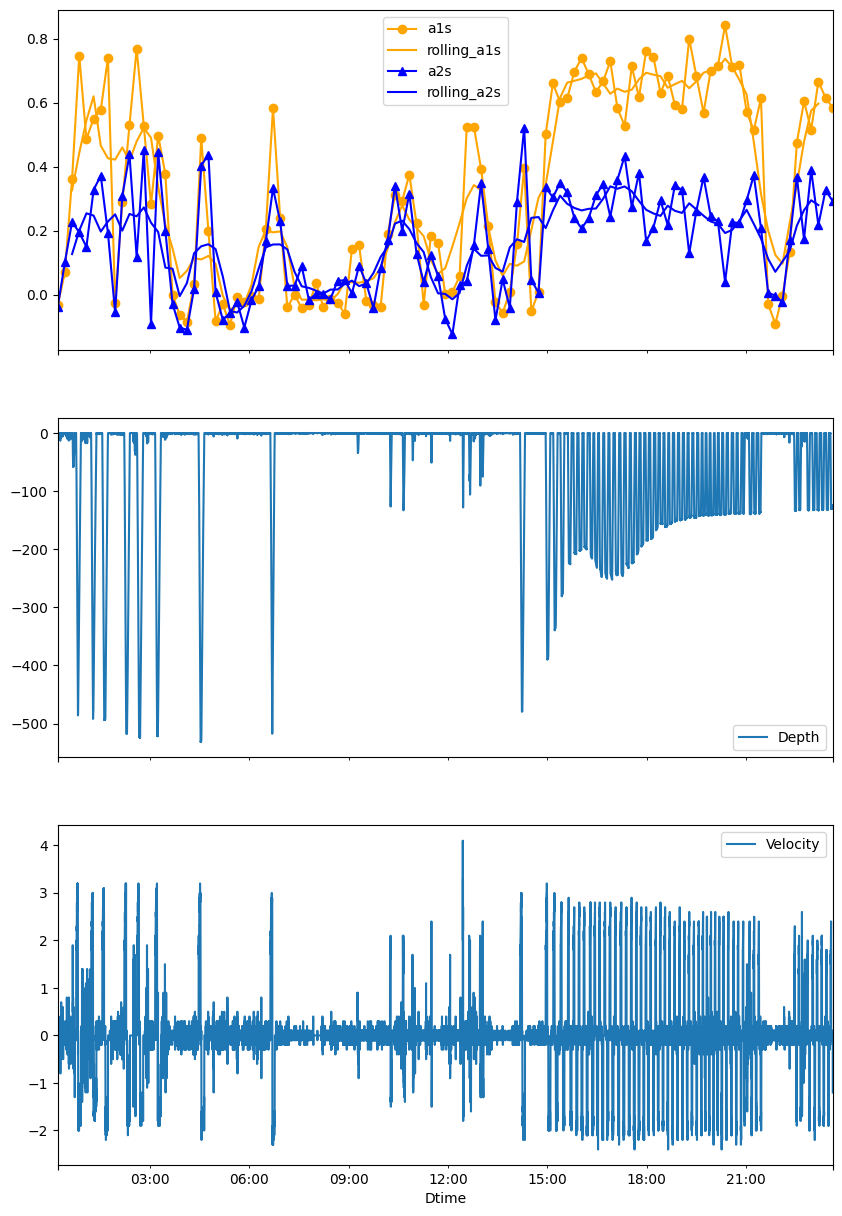

In [78]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 15))

day.plot(x="Dtime", y="Velocity", ax=axs[2])
day.plot(x="Dtime", y="Depth", ax=axs[1])
time_results.plot(x="Dtime", y="a1s", ax=axs[0], marker="o", color="orange")
#axs[0].fill_between(np.arange(len(time_results["Dtime"])), time_results["a1s"] - time_results["var1"], time_results["a1s"]+time_results["var1"] ,alpha=0.3, facecolor="orange")
#axs[0].fill_between(time_results["Dtime"].values, time_results["a1s"] - time_results["var1"], time_results["a1s"]+time_results["var1"],facecolor='orange', alpha=0.2, interpolate=True)
time_results.plot(x="Dtime", y="rolling_a1s", ax=axs[0], color="orange")
time_results.plot(x="Dtime", y="a2s", ax=axs[0], marker="^", color="blue")
#axs[0].fill_between(np.arange(len(time_results["Dtime"])), time_results["a2s"] - time_results["var2"], time_results["a2s"]+time_results["var2"] ,alpha=0.3, facecolor="orange")
#axs[0].fill_between(time_results["Dtime"].values, time_results["a2s"] - time_results["var2"], time_results["a2s"]+time_results["var2"],facecolor='blue', alpha=0.2, interpolate=True)

time_results.plot(x="Dtime", y="rolling_a2s", ax=axs[0], color="blue")

fig.show()
fig.savefig('results_with_uncertainty.png', bbox_inches='tight')

100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]


0.21001690156617633


100%|█████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


0.1629334287525622


100%|█████████████████████████████████████████| 100/100 [01:09<00:00,  1.44it/s]


0.19796143797415794


100%|█████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


0.33055960578280397


100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


0.49275429650885294


100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.47it/s]


0.1728512008575528


100%|█████████████████████████████████████████| 100/100 [01:09<00:00,  1.45it/s]


0.11442362746646588


100%|█████████████████████████████████████████| 100/100 [01:14<00:00,  1.34it/s]


0.2131598442799357


100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


0.23149575466470648


100%|█████████████████████████████████████████| 100/100 [01:16<00:00,  1.31it/s]


0.3548593820531095


100%|█████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]


0.1718932756166672


100%|█████████████████████████████████████████| 100/100 [01:13<00:00,  1.37it/s]


0.11273075739746621


100%|█████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


0.09251667851057739


100%|█████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


0.08117139343525846


100%|█████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


0.04502597189971037


100%|█████████████████████████████████████████| 100/100 [01:13<00:00,  1.36it/s]


0.10726428861061564


100%|█████████████████████████████████████████| 100/100 [01:10<00:00,  1.42it/s]


0.08729399104936807


100%|█████████████████████████████████████████| 100/100 [01:14<00:00,  1.35it/s]


0.029387159599646936


100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


0.04206477630992879


100%|█████████████████████████████████████████| 100/100 [01:12<00:00,  1.39it/s]


0.02085473738792504


100%|█████████████████████████████████████████| 100/100 [01:11<00:00,  1.40it/s]


0.06247178726658911


100%|█████████████████████████████████████████| 100/100 [01:10<00:00,  1.43it/s]


0.03415500677940822


100%|█████████████████████████████████████████| 100/100 [01:10<00:00,  1.41it/s]


0.01773365328033514


100%|█████████████████████████████████████████| 100/100 [01:15<00:00,  1.33it/s]


0.014070100217294445


100%|█████████████████████████████████████████| 100/100 [01:24<00:00,  1.18it/s]


0.006889790913023723


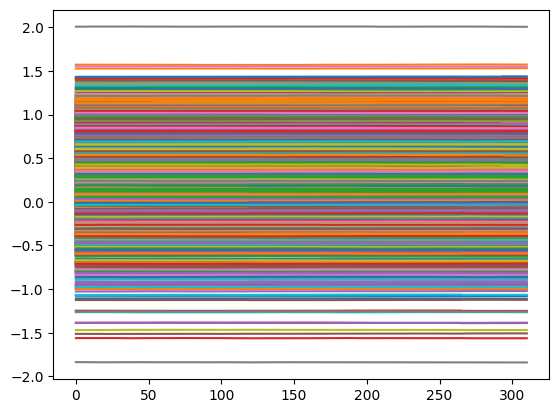

In [89]:
sigma_o = [0.05, 0.1, 0.2, 0.3, 0.5]
sigma_e = [0.05, 0.1, 0.2, 0.3, 0.5]
var_tot = []
for s_o in sigma_o:
    for s_e in sigma_e:
        last_a1s, last_a2s = test_var(s_o, s_e)
        for test in last_a1s:
            plt.plot(np.arange(311),test)
        var_tot.append(np.var(np.mean(last_a1s, axis = 1)))
        print(np.var(np.mean(last_a1s, axis = 1)))

100%|███████████████████████████████████████████| 10/10 [00:06<00:00,  1.61it/s]


0.0017326895735685817

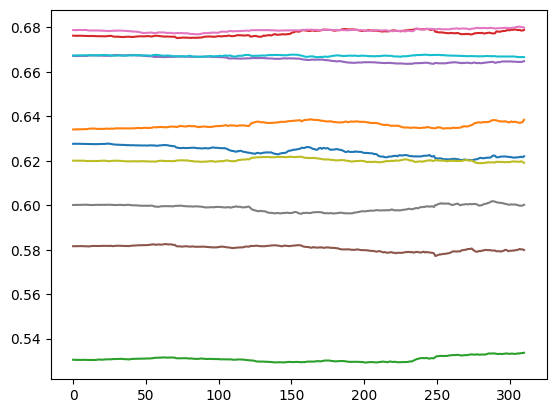

In [130]:
last_a1s, last_a2s = test_var(0.5, 0.5)
for test in last_a1s:
    plt.plot(np.arange(311),test)
np.var(np.mean(last_a1s, axis = 1))
np.var(np.mean(last_a2s, axis = 1))

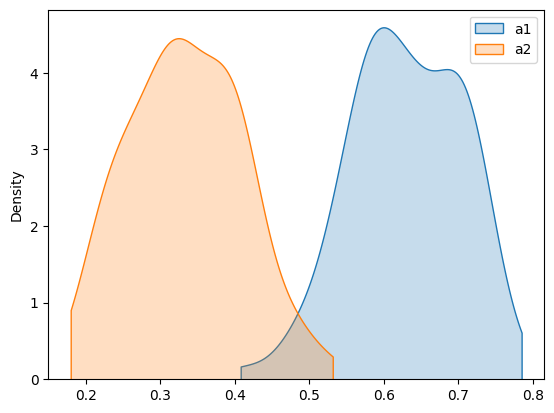

In [104]:
test_var_a1 = np.mean(last_a1s, axis = 1)
test_var_a2 = np.mean(last_a2s, axis = 1)
sns.kdeplot(test_var_a1, fill=True, label="a1", cut=0)
sns.kdeplot(test_var_a2, fill=True, label="a2", cut=0)
plt.legend()

In [90]:
var_tot

[0.21001690156617633,
 0.1629334287525622,
 0.19796143797415794,
 0.33055960578280397,
 0.49275429650885294,
 0.1728512008575528,
 0.11442362746646588,
 0.2131598442799357,
 0.23149575466470648,
 0.3548593820531095,
 0.1718932756166672,
 0.11273075739746621,
 0.09251667851057739,
 0.08117139343525846,
 0.04502597189971037,
 0.10726428861061564,
 0.08729399104936807,
 0.029387159599646936,
 0.04206477630992879,
 0.02085473738792504,
 0.06247178726658911,
 0.03415500677940822,
 0.01773365328033514,
 0.014070100217294445,
 0.006889790913023723]

In [30]:
final_a1s.mean(axis=1)

array([-0.32393425, -0.00547199, -0.09965049,  0.05268628,  0.07978089,
        0.02424021,  0.01255839,  0.00214959,  0.00403476,  0.00643152])

In [ ]:
epsilon = 0.1
final_a1s = []
final_a2s = []
for m in range(10):
    a1 = final_a1s[-1].mean() if m > 0 else 0
    a2 = final_a2s[-1].mean() if m > 0 else 0
    alg = run_smc(window=window, sigma_v=epsilon, a1=a1, a2=a2)
    a1s_tmp = np.array(alg.hist.X)[:, :, 2]
    a2s_tmp = np.array(alg.hist.X)[:, :, 3]
    wgts = np.array([w.W for w in alg.hist.wgts])
    final_a1s.append(np.average(a1s_tmp, weights=wgts, axis=1))
    final_a2s.append(np.average(a2s_tmp, weights=wgts, axis=1))
    epsilon *= 0.5

final_a1s = np.array(final_a1s)
final_a2s = np.array(final_a2s)
a1s = final_a1s.mean(axis=1)
a2s = final_a2s.mean(axis=1)

In [ ]:
print(a1s, a2s)

In [ ]:
for i in range(10):
    sns.kdeplot(np.array(final_a1s)[i, :], fill=True, label=f"iter {i+1}")

plt.legend()

In [ ]:
my_alg = run_smc(window, N=200)

In [ ]:
a1s_tmp = np.array(alg.hist.X)[:, :, 2]
a2s_tmp = np.array(alg.hist.X)[:, :, 3]
wgts = np.array([w.W for w in alg.hist.wgts])
a1s = np.average(a1s_tmp, weights=wgts, axis=1)
a2s = np.average(a2s_tmp, weights=wgts, axis=1)

In [ ]:
sns.kdeplot(a1s, fill=True, label="a1")
sns.kdeplot(a2s, fill=True, label="a2")
plt.legend()

In [ ]:
x_range = np.arange(len(window))
fig, axs = plt.subplots(2, 1, figsize=(10, 5))
axs[0].plot(x_range, a1s)
axs[1].plot(x_range, a2s)

In [ ]:

time_a1s = []
time_a2s = []
var_a1s = []
var_a2s = []
for window in tqdm(windows):
    final_a1s, final_a2s = estimate_a1_a2_on_window_SMC2(window, N=5)
    time_a1s.append(final_a1s)
    time_a2s.append(final_a2s)
    #var1, var2 = test_var(0.5, 0.5)
    #var_a1s.append(var1)
    #var_a2s.append(var2)
#var_a1s = np.array(var_a1s)
#var_a2s = np.array(var_a2s)
time_a1s = np.array(time_a1s)
time_a2s = np.array(time_a2s)
time_results = pd.DataFrame(
    {
        "Dtime": day["Dtime"].iloc[ids],
        "a1s": time_a1s[:].mean(axis = 1),
        "a2s": time_a2s[:].mean(axis = 1),
    }
)

  8%|███▍                                     | 9/109 [06:09<1:00:30, 36.31s/it]

In [134]:
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 15))

day.plot(x="Dtime", y="Velocity", ax=axs[2])
day.plot(x="Dtime", y="Depth", ax=axs[1])
time_results.plot(x="Dtime", y="a1s", ax=axs[0], marker="o", color="orange")
#axs[0].fill_between(np.arange(len(time_results["Dtime"])), time_results["a1s"] - time_results["var1"], time_results["a1s"]+time_results["var1"] ,alpha=0.3, facecolor="orange")
#axs[0].fill_between(time_results["Dtime"].values, time_results["a1s"] - time_results["var1"], time_results["a1s"]+time_results["var1"],facecolor='orange', alpha=0.2, interpolate=True)
time_results.plot(x="Dtime", y="rolling_a1s", ax=axs[0], color="orange")
time_results.plot(x="Dtime", y="a2s", ax=axs[0], marker="^", color="blue")
#axs[0].fill_between(np.arange(len(time_results["Dtime"])), time_results["a2s"] - time_results["var2"], time_results["a2s"]+time_results["var2"] ,alpha=0.3, facecolor="orange")
#axs[0].fill_between(time_results["Dtime"].values, time_results["a2s"] - time_results["var2"], time_results["a2s"]+time_results["var2"],facecolor='blue', alpha=0.2, interpolate=True)

time_results.plot(x="Dtime", y="rolling_a2s", ax=axs[0], color="blue")

fig.show()
fig.savefig('results_with_uncertainty.png', bbox_inches='tight')

 13%|█████▍                                    | 14/109 [00:09<01:05,  1.45it/s]


KeyboardInterrupt: 